In [1]:
%matplotlib inline

import copy
from datetime import date
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
import time
import torch as pt

sys.path.insert(0, '../..')

from function_space import DenseNet_tanh, DenseNet
from problems import Committor
from utilities import plot_moving_average, plot_loss_logs_extended, do_importance_sampling, do_importance_sampling_Wei, plot_control_for_DoubleWell1d, plot_loss_logs, plot_solution, save_exp_logs, load_exp_logs
from solver import EllipticSolver

%load_ext autoreload
%autoreload 2

device = pt.device('cuda')

In [2]:
class DenseNet_tanh_2(pt.nn.Module):
    def __init__(self, d_in, d_out, lr, arch=[30, 30], seed=42):
        super(DenseNet_tanh_2, self).__init__()
        pt.manual_seed(seed)
        self.nn_dims = [d_in] + arch + [d_out]
        self.W = [item for sublist in
                  [[pt.nn.Parameter(pt.randn(sum(self.nn_dims[:i + 1]), self.nn_dims[i + 1],
                                             requires_grad=True) * 0.1),
                    pt.nn.Parameter(pt.zeros(self.nn_dims[i + 1], requires_grad=True))] for
                   i in range(len(self.nn_dims) - 1)]
                  for item in sublist]

        for i, w in enumerate(self.W):
            self.register_parameter('param %d' % i, w)

        self.optim = pt.optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        for i in range(len(self.nn_dims) - 1):
            if i == len(self.nn_dims) - 2:
                x = pt.matmul(x, self.W[2 * i]) + self.W[2 * i + 1]
            else:
                x = pt.cat([x, pt.nn.functional.tanh(pt.matmul(x, self.W[2 * i])
                                                     + self.W[2 * i + 1]) ** 2], dim=1)
        return x

## Diffusion loss

In [3]:
d = 10
L = 30000
print_every = 1000
N = 50
delta_t = 0.001

seed = 42

problem = Committor(d=d)

models_diffusion = [EllipticSolver(problem, 'Diffusion', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200, K_test_log=10000,
                 K_boundary=50, alpha=[1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='diffusion', 
                loss_with_stopped=False),
              EllipticSolver(problem, 'Diffusion', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200, K_test_log=10000,
                 K_boundary=50, alpha=[10.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='diffusion', 
                loss_with_stopped=False),
              EllipticSolver(problem, 'Diffusion', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200, K_test_log=10000,
                 K_boundary=50, alpha=[100.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='diffusion', 
                loss_with_stopped=False)]

for model in models_diffusion:
    model.V = DenseNet_tanh_2(d_in=d, d_out=1, lr=0.001, seed=seed, arch=[d + 10, d, d, d]).to(device)

In [ ]:
for model in models_diffusion:
    model.train()

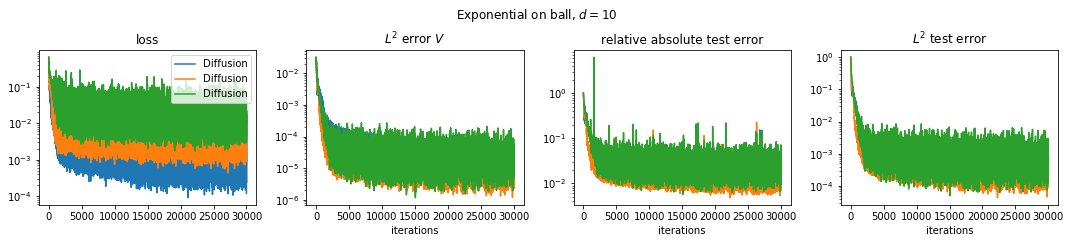

In [10]:
fig = plot_loss_logs_extended('Exponential on ball', models_diffusion)

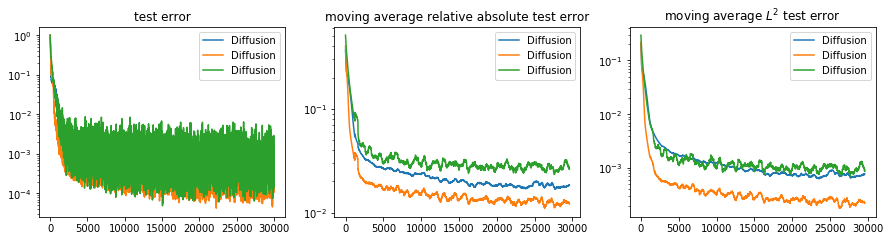

In [11]:
fig = plot_moving_average('Exponential on ball', models_diffusion)

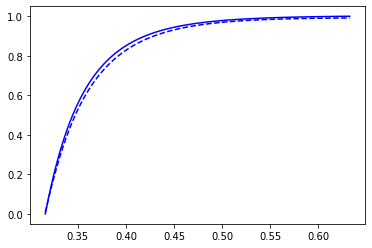

In [12]:
model = models_diffusion[2]

#X = pt.cat([pt.linspace(1, 2, 100).unsqueeze(1), pt.zeros(100, d - 1)], 1).to(device)
#X = pt.cat([pt.zeros(100, d - 1), pt.linspace(1, 2, 100).unsqueeze(1)], 1).to(device)
X = pt.cat([pt.linspace(1 / np.sqrt(d), 2 / np.sqrt(d), 100).unsqueeze(1).repeat(1, d)], 1).to(device)

plt.plot(X[:, 0].detach().cpu().numpy(), problem.v_true(X.detach()).squeeze().cpu().numpy(), color='blue')
plt.plot(X[:, 0].detach().cpu().numpy(), model.V(X).detach().cpu().numpy()[:, 0], '--', color='blue');

## PINN

In [5]:
d = 10
L = 30000
print_every = 1000
N = 50
delta_t = 0.001

seed = 42

problem = Committor(d=d)

models_pinn = [EllipticSolver(problem, 'PINN', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200, K_test_log=10000,
                 K_boundary=50, alpha=[0.001, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='PINN', 
                loss_with_stopped=False),
             EllipticSolver(problem, 'PINN', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200, K_test_log=10000,
                 K_boundary=50, alpha=[0.01, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='PINN', 
                loss_with_stopped=False),
             EllipticSolver(problem, 'PINN', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200, K_test_log=10000,
                 K_boundary=50, alpha=[0.1, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='PINN', 
                loss_with_stopped=False)]

for model in models_pinn:
    model.V = DenseNet_tanh_2(d, 1, lr=0.001, arch=[30, 30, 30, 30]).to(device)

In [ ]:
for model in models_pinn:
    model.train()

../../solver.py:919: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.V_L2_log.append(pt.mean(((self.V(X).squeeze() - pt.tensor(self.problem.v_true(X.detach())).float().squeeze())**2).detach().cpu() * self.delta_t_np).item())


0 - loss = 2.0675e-02 - v L2 error = 1.4987e-07 - 0.11


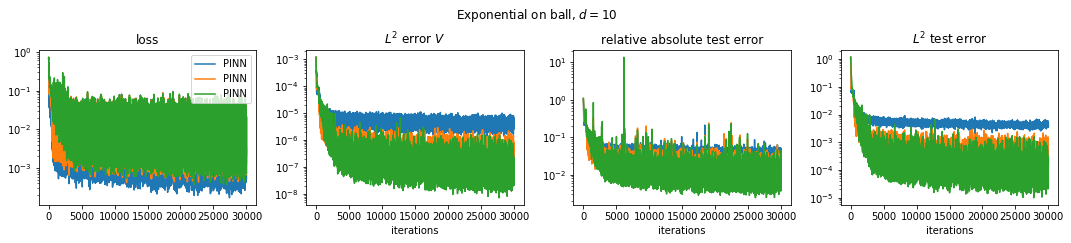

In [13]:
fig = plot_loss_logs_extended('Exponential on ball', models_pinn)

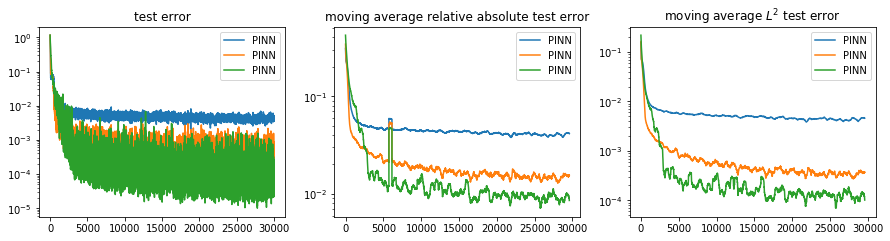

In [14]:
fig = plot_moving_average('Exponential on ball', models_pinn)

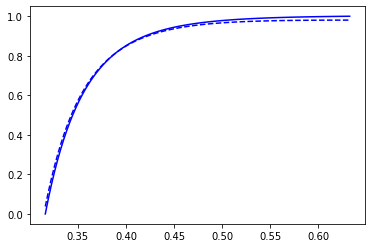

In [15]:
model = models_pinn[2]

#X = pt.cat([pt.linspace(1, 2, 100).unsqueeze(1), pt.zeros(100, d - 1)], 1).to(device)
#X = pt.cat([pt.zeros(100, d - 1), pt.linspace(1, 2, 100).unsqueeze(1)], 1).to(device)
X = pt.cat([pt.linspace(1 / np.sqrt(d), 2 / np.sqrt(d), 100).unsqueeze(1).repeat(1, d)], 1).to(device)

plt.plot(X[:, 0].detach().cpu().numpy(), problem.v_true(X.detach()).squeeze().cpu().numpy(), color='blue')
plt.plot(X[:, 0].detach().cpu().numpy(), model.V(X).detach().cpu().numpy()[:, 0], '--', color='blue');

## BSDE loss

In [7]:
d = 10
L = 30000
print_every = 100
N = 5000
delta_t = 0.001

seed = 42

problem = Committor(d=d)

models_bsde = [EllipticSolver(problem, 'BSDE', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200, K_test_log=10000,
                K_boundary=50, alpha=[0.01, 1.0], adaptive_forward_process=False, detach_forward=True,
                print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='BSDE', 
                loss_with_stopped=False)]

for model in models_bsde:
    model.V = DenseNet_tanh_2(d_in=d, d_out=1, lr=0.001, seed=seed, arch=[d + 10, d, d, d]).to(device)

In [8]:
for model in models_bsde:
    model.train()

0 - loss = 1.0792e+00, v L2 error = 6.6236e-02, n = 504, active: 0/200, 14.07
100 - loss = 1.0669e-01, v L2 error = 6.1335e-03, n = 428, active: 0/200, 21.35
200 - loss = 3.4853e-02, v L2 error = 1.4270e-03, n = 716, active: 0/200, 21.42
300 - loss = 9.7318e-03, v L2 error = 2.1772e-04, n = 654, active: 0/200, 21.30
400 - loss = 1.4530e-02, v L2 error = 2.7943e-04, n = 849, active: 0/200, 21.27
500 - loss = 7.5035e-03, v L2 error = 1.4418e-04, n = 1663, active: 0/199, 23.01
600 - loss = 4.9703e-03, v L2 error = 8.2153e-05, n = 795, active: 0/200, 21.68
700 - loss = 1.0749e-02, v L2 error = 1.1607e-04, n = 602, active: 0/199, 20.90
800 - loss = 4.8554e-03, v L2 error = 8.6346e-05, n = 481, active: 0/200, 21.24
900 - loss = 5.2302e-03, v L2 error = 4.7792e-05, n = 854, active: 0/200, 19.51
1000 - loss = 9.3603e-04, v L2 error = 1.8180e-05, n = 578, active: 0/200, 21.46
1100 - loss = 1.1898e-03, v L2 error = 2.4062e-05, n = 469, active: 0/200, 21.89
1200 - loss = 5.9686e-03, v L2 error = 

10200 - loss = 2.9734e-04, v L2 error = 4.2789e-06, n = 478, active: 0/199, 15.11
10300 - loss = 1.3672e-04, v L2 error = 1.3128e-05, n = 801, active: 0/200, 15.97
10400 - loss = 1.1525e-03, v L2 error = 2.3767e-05, n = 680, active: 0/200, 15.47
10500 - loss = 6.2497e-04, v L2 error = 1.9784e-05, n = 720, active: 0/200, 15.45
10600 - loss = 7.3479e-05, v L2 error = 7.4717e-06, n = 516, active: 0/200, 14.61
10700 - loss = 1.0699e-04, v L2 error = 3.1324e-06, n = 511, active: 0/200, 14.81
10800 - loss = 1.4253e-04, v L2 error = 1.1188e-05, n = 473, active: 0/200, 14.63
10900 - loss = 8.6836e-04, v L2 error = 1.6338e-05, n = 511, active: 0/200, 13.96
11000 - loss = 2.1241e-04, v L2 error = 5.9125e-06, n = 645, active: 0/200, 15.69
11100 - loss = 1.1140e-03, v L2 error = 9.5507e-06, n = 726, active: 0/200, 13.91
11200 - loss = 1.2216e-03, v L2 error = 1.8044e-05, n = 585, active: 0/200, 15.37
11300 - loss = 3.5576e-04, v L2 error = 1.4586e-05, n = 797, active: 0/200, 15.61
11400 - loss = 5

20200 - loss = 1.7895e-03, v L2 error = 2.6307e-05, n = 756, active: 0/199, 27.46
20300 - loss = 2.4511e-04, v L2 error = 1.4950e-05, n = 458, active: 0/200, 23.99
20400 - loss = 1.9507e-04, v L2 error = 4.8888e-06, n = 561, active: 0/200, 22.50
20500 - loss = 1.2488e-04, v L2 error = 1.1967e-05, n = 643, active: 0/200, 21.27
20600 - loss = 4.0487e-04, v L2 error = 1.2617e-05, n = 624, active: 0/200, 22.31
20700 - loss = 1.0972e-03, v L2 error = 1.2524e-05, n = 516, active: 0/198, 23.89
20800 - loss = 9.9594e-04, v L2 error = 1.2273e-05, n = 590, active: 0/200, 23.00
20900 - loss = 1.3310e-03, v L2 error = 9.0465e-06, n = 530, active: 0/200, 22.09
21000 - loss = 1.0397e-03, v L2 error = 1.1368e-05, n = 602, active: 0/200, 22.10
21100 - loss = 2.2557e-04, v L2 error = 5.2421e-06, n = 594, active: 0/199, 23.47
21200 - loss = 5.9580e-04, v L2 error = 8.6707e-06, n = 485, active: 0/200, 24.59
21300 - loss = 6.7846e-04, v L2 error = 1.4274e-05, n = 542, active: 0/200, 26.81
21400 - loss = 1

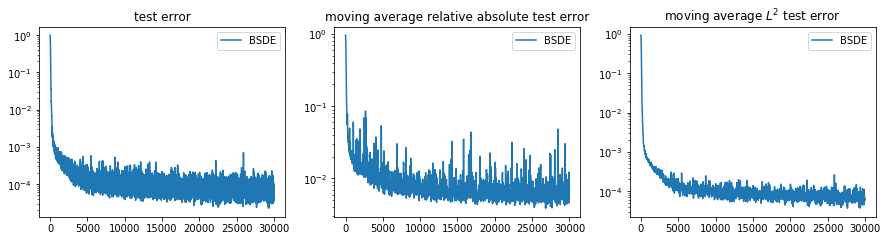

In [16]:
fig = plot_moving_average('Exponential on ball', models_bsde, moving_span=20)

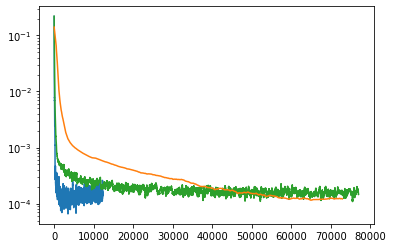

In [178]:
moving_span = 400

COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:pink', 'tab:gray', 'tab:brown', 'tab:cyan']

model_pinn = models_pinn[2]
model_bsde = models_bsde[0]
model_diffusion = models_diffusion[1]

#for model in models_pinn[2:3] + models_bsde + models_diffusion[1:2]:
#    plt.plot(np.cumsum(model.times)[:-moving_span], [np.mean(model.V_test_L2[i:i + moving_span]) for i in range(len(model.V_test_L2) - moving_span)], label=model.name)
plt.plot(np.cumsum(model_pinn.times)[:-moving_span], [np.mean(model_pinn.V_test_L2[i:i + moving_span]) for i in range(len(model_pinn.V_test_L2) - moving_span)], label=model.name)
plt.plot(np.cumsum(model_diffusion.times)[:-moving_span], [np.mean(model_diffusion.V_test_L2[i:i + moving_span]) for i in range(len(model_diffusion.V_test_L2) - moving_span)], label=model.name, color=COLORS[2])
plt.plot(np.cumsum(model_bsde.times)[:-moving_span], [np.mean(model_bsde.V_test_L2[i:i + moving_span]) for i in range(len(model_bsde.V_test_L2) - moving_span)], label=model.name, color=COLORS[1])

plt.yscale('log')

In [ ]:
fig = plot_moving_average('Exponential on ball', models_pinn[2:3] + models_bsde + models_diffusion[1:2], moving_span=400)

In [22]:
models_pinn[2].name = 'PINN loss'
models_diffusion[1].name = 'Diffusion loss'
models_bsde[0].name = 'BSDE loss'

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


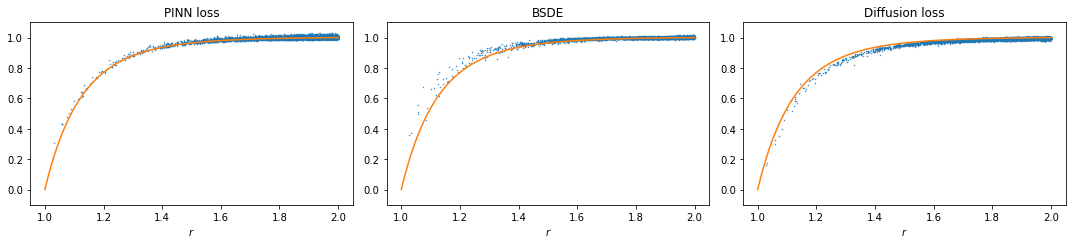

In [180]:
COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:pink', 'tab:gray', 'tab:brown', 'tab:cyan']

K = 5000

X = pt.randn(K, problem.d).to(device)
X = problem.boundary_distance_2 * X / pt.sqrt(pt.sum(X**2, 1)).unsqueeze(1) * (pt.rand(K).unsqueeze(1)**(1 / problem.d)).to(device)
selection = pt.sqrt(pt.sum(X**2, 1)) > problem.boundary_distance_1
X = X[selection, :]

#X = pt.rand(K, problem.d).to(device) * 2 - 1
#X = X / pt.sqrt(pt.sum(X**2, 1)).unsqueeze(1) * (pt.rand(K, problem.d).to(device) * (problem.boundary_distance_2 - problem.boundary_distance_1) + problem.boundary_distance_1)
#X_min = np.min(pt.sqrt(pt.sum(X**2, 1)).detach().cpu().numpy())
X_min = 1
X_ = pt.cat([pt.linspace(X_min / np.sqrt(d), 2 / np.sqrt(d), 100).unsqueeze(1).repeat(1, d)], 1).to(device)

fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))

for i, model in enumerate(models_pinn[2:3] + models_bsde + models_diffusion[1:2]):

    ax[i].set_title(model.name)
    ax[i].scatter(pt.sqrt(pt.sum(X**2, 1)).detach().cpu().numpy(), model.V(X).squeeze().detach().cpu().numpy(), s=0.2);
    ax[i].plot(np.linspace(X_min, 2, 100), problem.v_true(X_.detach()).squeeze().cpu().numpy(), color=COLORS[1])
    ax[i].set_ylim(-0.1, 1.1)
    ax[i].set_xlabel(r'$r$')

fig.tight_layout()
    
#fig.savefig('img/committor_d10_sampled_evaluations_3.pdf')


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


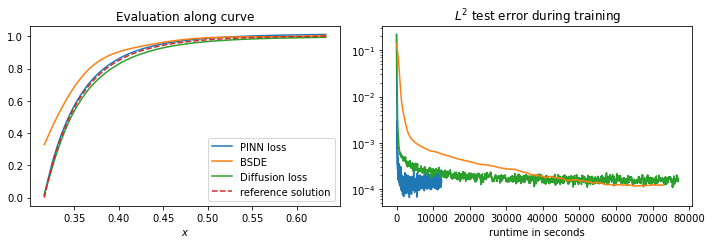

In [184]:
moving_span = 400

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))

model = models_pinn[2]

X = pt.cat([pt.linspace(1 / np.sqrt(d), 2 / np.sqrt(d), 100).unsqueeze(1).repeat(1, d)], 1).to(device)


for model in models_pinn[2:3] + models_bsde + models_diffusion[1:2]:
    ax[0].plot(X[:, 0].detach().cpu().numpy(), model.V(X).detach().cpu().numpy()[:, 0], label=model.name);

ax[0].plot(X[:, 0].detach().cpu().numpy(), problem.v_true(X.detach()).squeeze().cpu().numpy(), '--', label='reference solution')
ax[0].set_xlabel(r'$x$')
ax[0].legend();
ax[0].set_title('Evaluation along curve')

#ax[1].set_title('Test error during training')
#for model in models_pinn[2:3] + models_bsde + models_diffusion[1:2]:
#    ax[1].plot([np.mean(model.V_test_L2[i:i + moving_span]) for i in range(len(model.V_test_L2) - moving_span)], label=model.name)
#ax[1].set_yscale('log')
#ax[1].legend()
#ax[1].set_xlabel('gradient steps');

moving_span = 400

COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:pink', 'tab:gray', 'tab:brown', 'tab:cyan']

model_pinn = models_pinn[2]
model_bsde = models_bsde[0]
model_diffusion = models_diffusion[1]

ax[1].set_title(r'$L^2$ test error during training')
#for model in models_pinn[2:3] + models_bsde + models_diffusion[1:2]:
#    plt.plot(np.cumsum(model.times)[:-moving_span], [np.mean(model.V_test_L2[i:i + moving_span]) for i in range(len(model.V_test_L2) - moving_span)], label=model.name)
ax[1].plot(np.cumsum(model_pinn.times)[:-moving_span], [np.mean(model_pinn.V_test_L2[i:i + moving_span]) for i in range(len(model_pinn.V_test_L2) - moving_span)], label=model.name)
ax[1].plot(np.cumsum(model_diffusion.times)[:-moving_span], [np.mean(model_diffusion.V_test_L2[i:i + moving_span]) for i in range(len(model_diffusion.V_test_L2) - moving_span)], label=model.name, color=COLORS[2])
ax[1].plot(np.cumsum(model_bsde.times)[:-moving_span], [np.mean(model_bsde.V_test_L2[i:i + moving_span]) for i in range(len(model_bsde.V_test_L2) - moving_span)], label=model.name, color=COLORS[1])

ax[1].set_yscale('log')
ax[1].set_xlabel('runtime in seconds');


fig.tight_layout()

#fig.savefig('img/committor_d10_curve_loss_3.pdf')
